In [1]:
%tensorflow_version 1.x
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

from collections import deque

import pickle

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
class env_opt_sd1:
  def one_encode(self,n1,n2,l,i1,i2,mem):
    cs=np.zeros(l*3)
    cs[n1]=i1
    for i in n2:
      cs[i+l]=i2
    cs[2*l:]=mem
    return(cs)
  def __init__(self,s,d):
    self.jun_link=[[1,3],[0,2],[1,3,4],[0,2,5],[2,5],[3,4]]
    self.jun_dist=[[10,15],[10,5],[5,7,3],[15,7,11],[3,7],[7,11]]
    self.memory=np.zeros(len(self.jun_link))
    self.memory[s]=1
    self.pos=s
    self.targs=d
    self.state=self.one_encode(s,d,len(self.jun_link),len(self.jun_link[s]),1,self.memory)
    self.game_fold=r'/content/drive/My Drive/Colab Notebooks/sales_vehicle/optimization/j2js_opt/game3/episodes'
    self.episode=1
    self.actions=np.array(['1','2','3'])
    #self.action_dict={0:'n',1:'ne',2:'e',3:'se',4:'s',5:'sw',6:'w',7:'nw'}
    #self.r_dict={'n':-1,'ne':-1,'e':0,'se':1,'s':1,'sw':1,'w':0,'nw':-1}
    #self.c_dict = {'n': 0, 'ne': 1, 'e': 1, 'se': 1, 's': 0, 'sw': -1, 'w': -1, 'nw': -1}
    #self.rw_max=self.rmax*self.cmax
    self.net_rw=0
    self.n_steps=1
    self.txt_init()
  def list_data(self):
    fn=self.game_fold+'/'+'jun_link.data'
    with open(fn, 'wb') as filehandle:
      pickle.dump(self.jun_link, filehandle)
    fn=self.game_fold+'/'+'jun_dist.data'
    with open(fn, 'wb') as filehandle:
      pickle.dump(self.jun_dist, filehandle)
  def txt_init(self):
        fp=self.game_fold+'/'+str(self.episode)+'.txt'
        f=open(fp,'w')
        s=str(self.pos)#+','#+str(self.targ)+'\n'
        for i in self.targs:
          s+=','+str(i)
        s+='\n'
        f.write(s)
        f.close()
  def txt_log(self):
        s=str(self.pos)+'\n'
        fp=self.game_fold+'/'+str(self.episode)+'.txt'
        f=open(fp,'a')
        f.write(s)
        f.close()
  def action_sample(self):
    return(random.randint(0,len(self.jun_link[self.pos])-1))
  def state_update(self):
    ls=len(self.state)
    state=np.zeros(ls)
    l=int(ls/3)
    cs=np.zeros(l)
    cs[self.pos]=len(self.jun_link[self.pos])
    t=np.zeros(l)
    for i in self.targs:
      t[i]=1
    mem=self.memory
    state[0:l]=cs
    state[l:2*l]=t
    state[2*l:]=mem
    self.state=state

  def step(self,action):
    #check position if valid
    self.n_steps+=1
    temp=len(self.jun_link[self.pos])
    if(action>=temp):
      reward=-100  ## May need to alter
      done=0
      print("invalid move")
      #print("ation:"+str(action))
      #print("temp"+str(temp))
    else:
      new_pos=self.jun_link[self.pos][action]
      #check if target is reached
      if(new_pos in self.targs):
        reward=10  ## may need to alter
        self.targs.remove(new_pos)
        self.memory=np.zeros(len(self.jun_link))
        self.pos=new_pos
        self.memory[self.pos]=1
        self.state_update()
        if(len(self.targs)==0):
          done=2
          reward=100
          print('All targets reached')
        else:
          done=0
          reward=10
          print('one of the target reached')
      else:
        ##check target memory
        #print(self.memory[new_pos])
        #print(self.memory)
        #print(new_pos)
        if(self.memory[new_pos]==1):
          reward=-10 ## May need to alter
          done=1
          print("Repeated destination")
        else:
          self.memory[new_pos]=1
          self.pos=new_pos
          self.state_update()
          reward=-1  #may need to reinforce exploration
          done=0
          print("moved to valid position")
    self.txt_log()
    self.net_rw+=reward
    return(self.state,reward,done)
  def reset(self,s,d):
    self.memory=np.zeros(len(self.jun_link))
    self.memory[s]=1
    self.pos=s
    self.targ=d
    self.state=self.one_encode(s,d,len(self.jun_link),len(self.jun_link[s]),1,self.memory)
    self.episode+=1
    
    #self.action_dict={0:'n',1:'ne',2:'e',3:'se',4:'s',5:'sw',6:'w',7:'nw'}
    #self.r_dict={'n':-1,'ne':-1,'e':0,'se':1,'s':1,'sw':1,'w':0,'nw':-1}
    #self.c_dict = {'n': 0, 'ne': 1, 'e': 1, 'se': 1, 's': 0, 'sw': -1, 'w': -1, 'nw': -1}
    #self.rw_max=self.rmax*self.cmax
    self.net_rw=0
    self.n_steps=1
    self.txt_init()

In [0]:
class DQN:
    def __init__(self, env):
        self.env = env
        self.memory = deque(maxlen=200000)
        self.batch_size=32
        self.gamma = 0.85
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.01
        self.tau = .125

        self.model = self.create_model()
        self.target_model = self.create_model()
        #self.model.summary()
        #self.target_model.summary()

    def create_model(self):
        model = Sequential()
        state_shape = self.env.state.shape      #self.env.observation_space.shape
        print('action_shape:')
        print(self.env.actions.shape[0])
        model.add(Dense(64, input_dim=state_shape[0], activation="relu"))
        model.add(Dense(64, activation="relu"))
        model.add(Dense(32, activation="relu"))
        model.add(Dense(32, activation="relu"))
        model.add(Dense(16, activation="relu"))
        model.add(Dense(self.env.actions.shape[0]))
        model.compile(loss="mean_squared_error",
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def act(self, state):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon:
            return self.env.action_sample()
        return np.argmax(self.model.predict(state)[0])

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):

        batch_size = min(self.batch_size,1024*4)
        self.batch_size+=1
        if len(self.memory) < batch_size:
            return

        samples = random.sample(self.memory, batch_size)
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = self.target_model.predict(state)
            # print(type(target))
            # print(target.shape)
            if done:
                target[0][action] = reward
            else:
                Q_future = max(self.target_model.predict(new_state)[0])
                target[0][action] = reward + Q_future * self.gamma
            self.model.fit(state, target, epochs=1, verbose=0)

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)

    def save_model(self, fn):
        self.model.save('/content/drive/My Drive/Colab Notebooks/sales_vehicle/optimization/j2js_opt/game3/models/'+fn)

In [0]:
def randsd(env):
  s=random.randint(0,len(env.jun_link)-1)
  d=random.randint(2,len(env.jun_link))
  targ=[]
  for i in range(d):
    temp=random.randint(0,len(env.jun_link)-1)
    if(temp==s or temp in targ):
      continue
    targ.append(temp)
  return(s,targ)

In [5]:
env=env_opt_sd1(1,[3,5])
gamma = 0.9
epsilon = .95

trials = 100000
trial_len = len(env.jun_link)
succ_log=[]
# updateTargetNetwork = 1000
dqn_agent = DQN(env=env)
steps = []
succ=0
for trial in range(trials):
    temp_s,temp_d=randsd(env)
    env.reset(temp_s,temp_d)
    cur_state = env.state.reshape(1, len(env.state))
    #print('YOLO')
    for step in range(trial_len):
        action = dqn_agent.act(cur_state)
        new_state, reward, done= env.step(action)

        # reward = reward if not done else -20
        new_state = new_state.reshape(1, len(env.state))
        dqn_agent.remember(cur_state, action, reward, new_state, done)

        dqn_agent.replay()  # internally iterates default (prediction) model
        dqn_agent.target_train()  # iterates target model

        cur_state = new_state
        if done>0:
            break
    if done==1:
        print("Failed to complete in trial {}".format(trial))
        suc_perc=succ*100/(trial+1)
        print(str(suc_perc)+'% of success')
        succ_log.append(suc_perc)
        #if step % 10 == 0:
        #    dqn_agent.save_model("trial-{}.model".format(trial))
    else:
        print("Completed in {} trials".format(trial))
        succ+=1
        suc_perc=succ*100/(trial+1)
        succ_log.append(suc_perc)
        print(str(suc_perc)+'% of success')
        if(succ%100==0):
          dqn_agent.save_model("success_trial-{}.model".format(trial))

Streaming output truncated to the last 5000 lines.
invalid move
invalid move
invalid move
invalid move
Completed in 521 trials
85.44061302681992% of success
moved to valid position
invalid move
invalid move
invalid move
invalid move
invalid move
Completed in 522 trials
85.46845124282983% of success
invalid move
invalid move
invalid move
invalid move
invalid move
invalid move
Completed in 523 trials
85.49618320610686% of success
moved to valid position
invalid move
invalid move
invalid move
invalid move
invalid move
Completed in 524 trials
85.52380952380952% of success
moved to valid position
invalid move
invalid move
invalid move
invalid move
invalid move
Completed in 525 trials
85.55133079847909% of success
moved to valid position
invalid move
invalid move
invalid move
invalid move
invalid move
Completed in 526 trials
85.57874762808349% of success
invalid move
invalid move
invalid move
invalid move
invalid move
invalid move
Completed in 527 trials
85.60606060606061% of success
invalid

KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

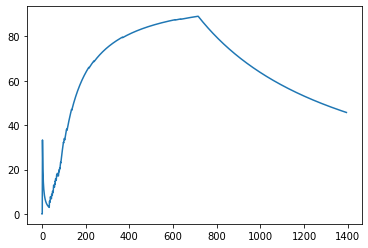

In [14]:
x=range(trial)
ll=710
ul=720
#plt.plot(x[ll:ul],succ_log[ll:ul])
plt.plot(x,succ_log)
plt.show()

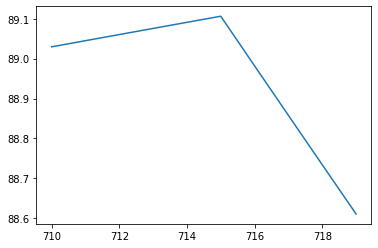

In [13]:
#plt.plot(x,succ_log)
plt.plot(x[ll:ul],succ_log[ll:ul])
plt.savefig('/content/drive/My Drive/Colab Notebooks/sales_vehicle/optimization/j2js_opt/game3/succ_plot_closeup.png')